# Chicago L Ridership

This Jupyter Notebook analyzes the ridership of the Chicago e"L"evated public transportation system. Ridership numbers come from Chicago's open data portal, found here: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f

In [1]:
# Import pandas for our data analysis
import pandas as pd

The questions of interest are: 

1. Which stop has the highest average ridership per day, and what is it?
2. Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it?

I will go about this by importing the data into a pandas DataFrame, getting a feel for what the data can tell me about ridership numbers, then grouping the ridership numbers by weekday while finding a resource that lists holiday days and week days for the last 16 years.

In [2]:
ridership = pd.read_json('https://data.cityofchicago.org/resource/mh5w-x5kh.json')
print(ridership.head())
print(ridership.shape)

                 date daytype  rides  station_id    stationname
0 2016-11-24 18:00:00       W    905       41010       Rockwell
1 2016-11-20 18:00:00       W   3538       41340        LaSalle
2 2016-11-14 18:00:00       W   5095       41380      Bryn Mawr
3 2016-11-08 18:00:00       W  16620       41450  Chicago/State
4 2016-11-25 18:00:00       A   3130       40560  Jackson/State
(1000, 5)


I'm not getting the full dataset this way. I think I need an AppToken to access the full dataset. Let's just download the json format to our local drive.

In [3]:
ridership = pd.read_csv('ridership.csv')
print(ridership.head())
print(ridership.shape)

   station_id         stationname        date daytype  rides
0       40010  Austin-Forest Park  01/01/2001       U    290
1       40020         Harlem-Lake  01/01/2001       U    633
2       40030        Pulaski-Lake  01/01/2001       U    483
3       40040        Quincy/Wells  01/01/2001       U    374
4       40050               Davis  01/01/2001       U    804
(826894, 5)


Now let's try to answer the question. Which station has the highest average ridership? We'll accomplish this by using pandas' 'groupby' functionality to group by each station, take the mean of the number of rides over the whole time period, then sort by that average to find the highest-ridership stations.

In [4]:
mean_ridership = ridership.groupby(by='stationname')['rides'].mean()
mean_ridership.sort_values(ascending=False, inplace=True)
mean_ridership.head()

stationname
Clark/Lake            13661.190402
Lake/State            13299.597592
Chicago/State         12944.953208
95th/Dan Ryan         10859.289046
Belmont-North Main    10440.290384
Name: rides, dtype: float64

### Question 1 Answer
So it looks like *Clark/Lake* is the stop with the highest average idership over the time period measured.

In [5]:
# Sanity check
ridership[ridership['stationname'] == 'Clark/Lake'].mean()

station_id    40380.000000
rides         13661.190402
dtype: float64

That's more like it. Now, the API Docs give us the following useful information:

>This list shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001. Dataset shows entries at all turnstiles, combined, for each station. Daytypes are as follows: W=Weekday, A=Saturday, U=Sunday/Holiday. See attached readme file for information on how these numbers are calculated.

>From https://dev.socrata.com/foundry/data.cityofchicago.org/mh5w-x5kh
    
So now we know that it should be easy enough for us to sort through the day for the second question. 

In [6]:
# Get only weekday values
weekday_ridership = ridership[ridership.daytype == 'W']
stddev_wd_ridership = weekday_ridership.groupby(by='stationname')['rides'].std()
stddev_wd_ridership.sort_values(ascending=False, inplace=True)
stddev_wd_ridership.head()

stationname
Lake/State            4292.931370
Washington/State      3890.640503
Addison-North Main    3289.670003
Clark/Lake            2742.644346
Fullerton             2602.717176
Name: rides, dtype: float64

### Question 2 Answer
It looks like Lake/State is the station that has the highest standard deviation in weekday ridership at 4293 riders per day.

## Just for Fun

What other fun things can we do with this data? Let's add context to the mean numbers we calculated by looking at the ridership over time!

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

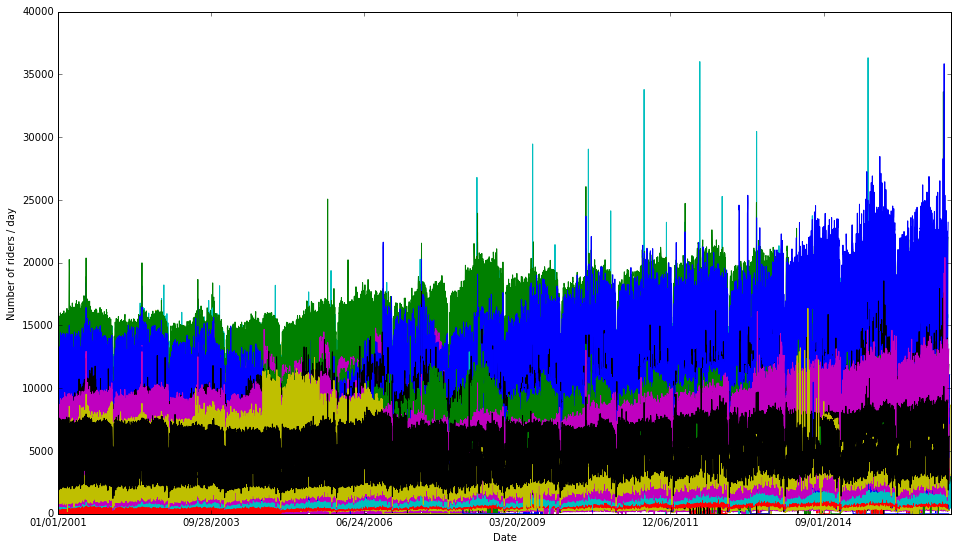

In [8]:
# Use groupby to get the data associated with each individual station
by_station = ridership.groupby(by='stationname')

# Get a useless but visually cool timeseries plot to get a feel for the data
fh = plt.figure(figsize=(16,9))
ax = fh.add_subplot(111)
for station, df in by_station:
    df.plot(x='date', y='rides', ax=ax, label=station, legend=False, style={'linestyle':'None', 'marker': '.'})

daterange = plt.xlim()
plt.ylabel('Number of riders / day')
plt.xlabel('Date')
plt.show()

Well, that is not very useful. Let's calculate a moving average to smooth out the noise, and only look at the top 10 stations by average ridership to limit the distracting and dense data.

/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=28).mean()
/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


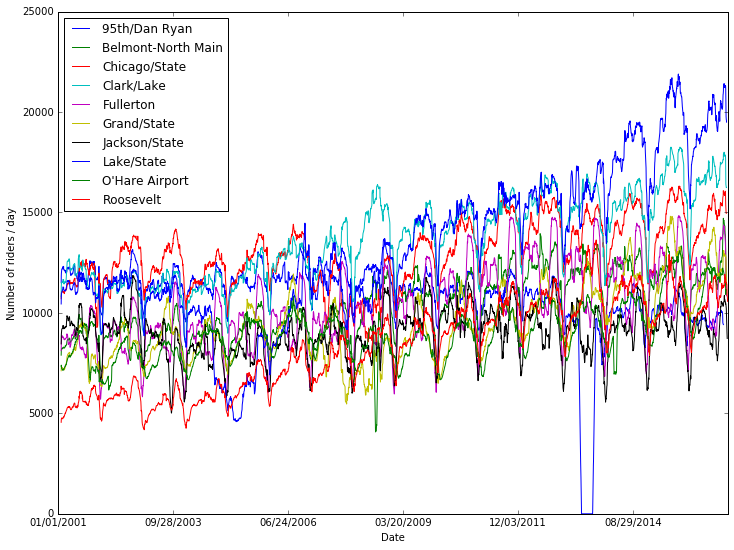

In [13]:
top_stations = mean_ridership.head(10).index.tolist()
# Get a useless but visually cool timeseries plot to get a feel for the data
fh = plt.figure(figsize=(12,9))
ax = fh.add_subplot(111)
for station, df in by_station:
    if station not in top_stations:
        continue
    df['rides'] = pd.rolling_mean(df['rides'], 28)
    df.plot(x='date', y='rides', ax=ax, label=station, legend=True)

daterange = plt.xlim()
plt.ylabel('Number of riders / day')
plt.xlabel('Date')
plt.show()

Interesting! So even though 95th/Dan Ryan has the highest ridership and is continuing to grow, Clark/Lake has the highest ridership over the entire time period. It looks like the 